## Dilated TCN - Credit Card Anomaly Detection         
#### Version 6 - PCA Dimension reduction and Keras Tuner on TCN Hyperparameters.     

##### Import libraries and packages 

In [1]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys

## Print to screen the software versions.... 
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)




Python:  3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]
pandas:  2.1.1
numpy:  1.26.1
seaborn:  0.13.0
matplotlib:  3.8.0
sklearn:  1.3.1
Keras:  2.14.0
Tensorflow:  2.14.0


##### Visualisation Class - for confusion matrix and plot Anomalies 

In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

##### Import csv file 

In [3]:
df = pd.read_csv("data/creditcard.csv", sep=",", index_col=None)
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


##### Standardise Time and Amount values 

In [5]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,1.641931,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.350151,0
284803,1.641952,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,-0.254117,0
284804,1.641974,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,-0.081839,0
284805,1.641974,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.313249,0
284806,1.642058,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,0.514355,0


##### Create 2 dataframes - one with classified normal data, and one with classified anomalies  

In [6]:
anomalies = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

anomalies.shape, normal.shape


((492, 31), (284315, 31))

Note - their are only 492 anomalies in the data - about 0.173% of the data

In [7]:
import matplotlib.pyplot as plt
import plotly.express as px

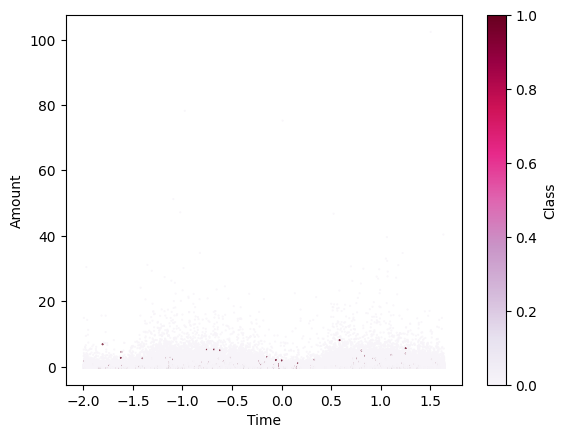

In [8]:
# plt.scatter(df['Time'] ,df['Amount'], s=0.2, c=df['Class'], cmap='PuRd')
# plt.colorbar()
# ax = plt.axes()
# ax.set_facecolor("yellow")
# plt.show()
ax1 = df.plot.scatter(x='Time', y='Amount', s=0.2, c='Class', cmap='PuRd', facecolor='yellow')


In [ ]:
### Try plotly ..... too many points for plotly 
fig = px.scatter(df, x='Time', y='Amount', color='class')
fig.show()

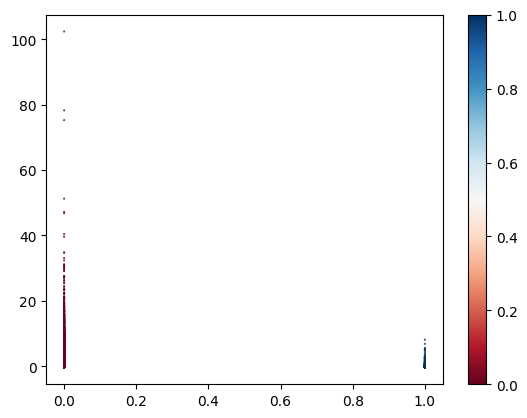

In [9]:
plt.scatter(df['Class'] ,df['Amount'], s=0.2, c=df['Class'], cmap='RdBu')
plt.colorbar()
# ax = plt.axes()
# ax.set_facecolor("yellow")
plt.show()

### Use PCA dimension reduction  

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [11]:
## Seperate the x-y values from the concentrations....
## Treat x-y as our input variables:  
dfY = df[['Time','Class']].copy()
dfX = df[['V1','V2', 'V3', 'V4', 'V5', 'V6','V7', 'V8', 'V9', 'V10', 'V11','V12', 'V13', 'V14', 'V15', 'V16','V17', 'V18', 'V19', 'V20', 'V21','V22', 'V23', 'V24', 'V25', 'V26','V27', 'V28', 'Amount' ]].copy()

In [12]:
dfX.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


##### V1-V28 have been standardised with a mean of zero - while Amount is now standardised. However, anomalies are still in the data. 

In [13]:
### Function to calculate the variance for each number of PCA principle components:

def get_variance(X, n):
    scaler = StandardScaler()
    pca = PCA(n_components=n)
    ## pca.fit(scaler.fit_transform(X))
    pca.fit((X))
    return pca.explained_variance_ratio_.cumsum()[-1:]


In [14]:
## Print the cumilative variance across 29 PCs 
for i in range(1,30):
    print('Components:\t', i, '=\t', get_variance(dfX, i), 
          '\tCumulative Variance')

Components:	 1 =	 [0.12417222] 	Cumulative Variance
Components:	 2 =	 [0.2234664] 	Cumulative Variance
Components:	 3 =	 [0.29733397] 	Cumulative Variance
Components:	 4 =	 [0.36262769] 	Cumulative Variance
Components:	 5 =	 [0.42544088] 	Cumulative Variance
Components:	 6 =	 [0.48208509] 	Cumulative Variance
Components:	 7 =	 [0.53294069] 	Cumulative Variance
Components:	 8 =	 [0.57799383] 	Cumulative Variance
Components:	 9 =	 [0.61607355] 	Cumulative Variance
Components:	 10 =	 [0.65360279] 	Cumulative Variance
Components:	 11 =	 [0.68635517] 	Cumulative Variance
Components:	 12 =	 [0.71797014] 	Cumulative Variance
Components:	 13 =	 [0.7491198] 	Cumulative Variance
Components:	 14 =	 [0.77817805] 	Cumulative Variance
Components:	 15 =	 [0.80458168] 	Cumulative Variance
Components:	 16 =	 [0.82877959] 	Cumulative Variance
Components:	 17 =	 [0.85151805] 	Cumulative Variance
Components:	 18 =	 [0.87381225] 	Cumulative Variance
Components:	 19 =	 [0.89543172] 	Cumulative Variance
Comp

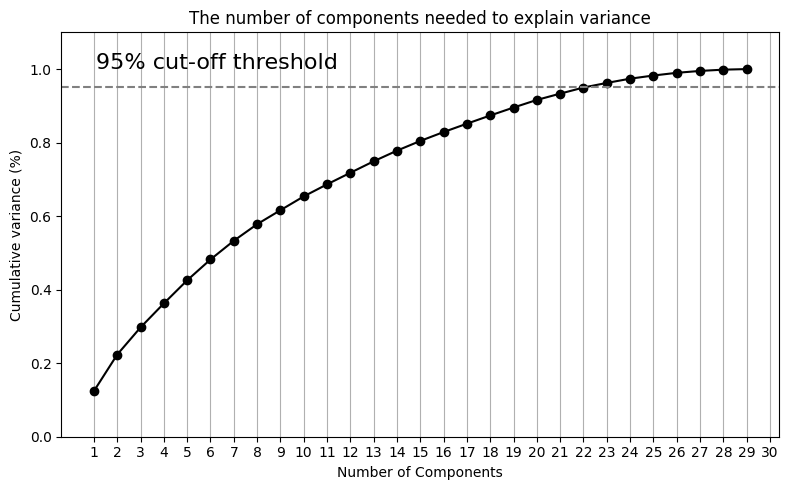

In [15]:
### Show this informaion in graphical form - with a 95% cutoff

scaler = StandardScaler()
data_rescaled = scaler.fit_transform(dfX)

## pca = PCA().fit(data_rescaled)
pca = PCA().fit(dfX)

plt.rcParams["figure.figsize"] = (8,5)

fig, ax = plt.subplots()
xi = np.arange(1, 30, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 31, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='grey', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.tight_layout()
plt.savefig('pcavisualize_1.png', dpi=300)
plt.show()

#### Data has obviously been created in such a way as to avoid PCA dim reduction - none of the dimensions have much more variance than the others :( 
    Could try to reduce the dimensions to 3 .... give it a go .... :)

In [16]:
### Define function for the PCA fit and inverse transform: 
def transform_pca(X, n):

    pca = PCA(n_components=n)
    pca.fit(X)
    X_new = pca.inverse_transform(pca.transform(X))

    return X_new

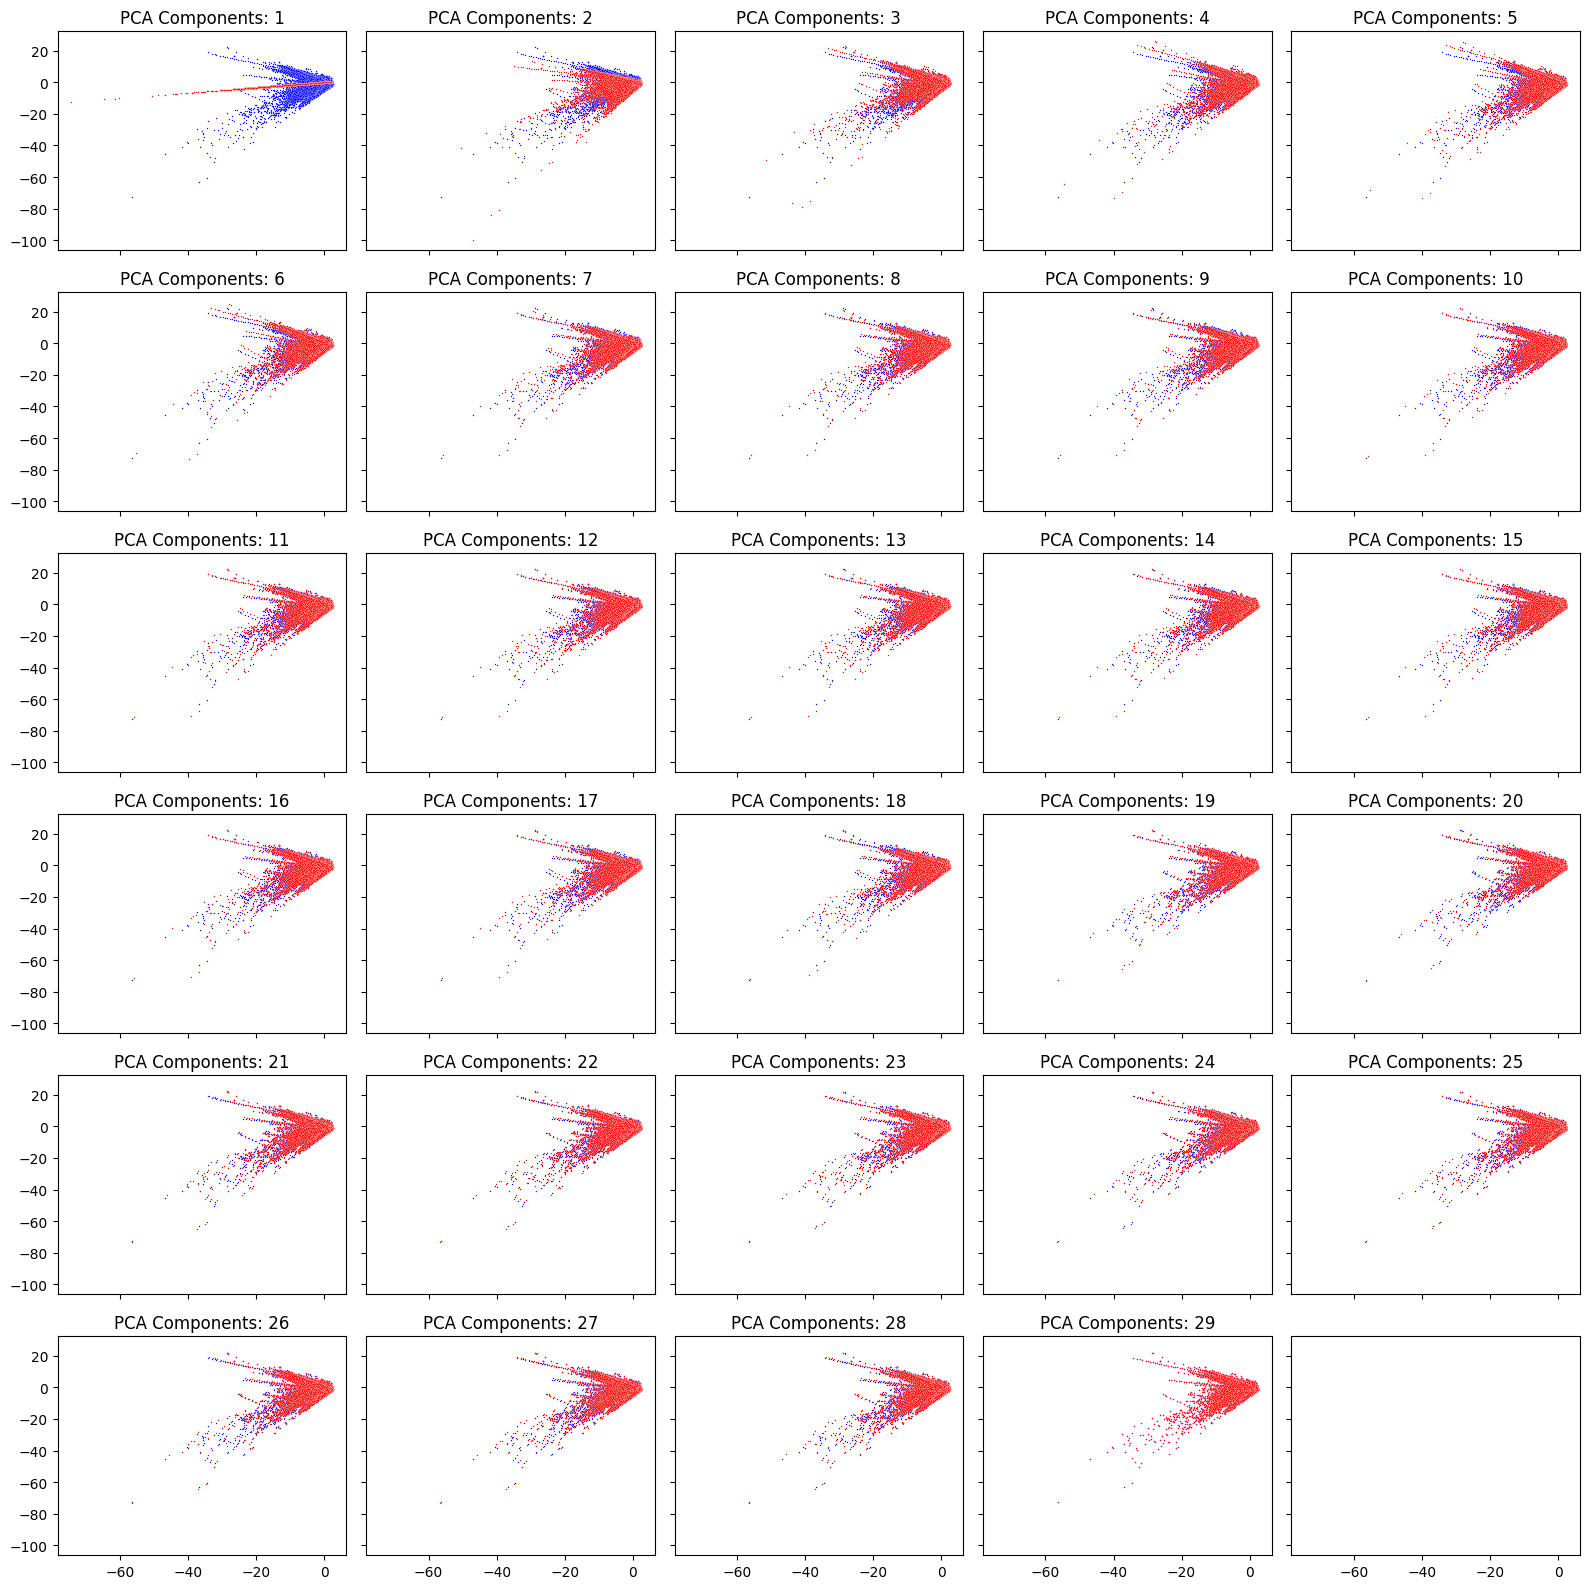

In [17]:
### Visualise the original data overlayered against the PCA inverse transform data:
## Define view parameters
rows = 6
cols = 5
comps = 1

## scaler = StandardScaler()
X_scaled = dfX.to_numpy()

fig, axes = plt.subplots(rows, 
                         cols, 
                         figsize=(16,16), 
                         sharex=True, 
                         sharey=True)

# Scatter of PCA (Black) and original (grey)  
for row in range(rows):
    for col in range(cols):
        try:
            X_new = transform_pca(X_scaled, comps)
            ax = sns.scatterplot(x=X_scaled[:, 0], 
                                 y=X_scaled[:, 1], 
                                 ax=axes[row, col], 
                                 color='blue', 
                                 s=1)
            ax = sns.scatterplot(x=X_new[:, 0], 
                                 y=X_new[:, 1], 
                                 ax=axes[row, col], 
                                 color='red',
                                 s=1)
            ax.set_title(f'PCA Components: {comps}');

            comps += 1
        except:
            pass
plt.tight_layout()
## plt.savefig('pcavisualize_2.png', dpi=300)

### Due to the imbalance between class 0 and 1 ...... Try PCA on smaller sample of class 0 data and then add the anomalies.    
Remember - normal has the dataset with class=0 and anomaly has class=1     
We can use 10,000 normal datasets plus the anomalies and try again ......    

In [18]:
for f in range(0, 20):
    normal = normal.iloc[np.random.permutation(len(normal))]
    
### Create a data_set with 10000 normal data entries and the anomalies
data_set = pd.concat([normal[:10000], anomalies])

In [19]:
dfY = data_set[['Time','Class']]
dfX = data_set[['V1','V2', 'V3', 'V4', 'V5', 'V6','V7', 'V8', 'V9', 'V10', 'V11','V12', 'V13', 'V14', 'V15', 'V16','V17', 'V18', 'V19', 'V20', 'V21','V22', 'V23', 'V24', 'V25', 'V26','V27', 'V28', 'Amount' ]]

In [20]:
print(dfX.head())
print(dfY.head())

              V1        V2        V3        V4        V5        V6        V7  \
113487 -1.471961  1.600659  1.115029 -0.294823 -0.209755 -0.293917  0.361163   
62296  -1.371685  0.251828  2.307824  0.164892 -1.152729  0.895349  1.169520   
244398  0.631950 -3.344474 -2.806180 -0.437530 -0.813820 -0.653302  1.034876   
201946 -1.596577 -0.144084  1.339459 -0.799004 -1.058086  1.311837  1.775417   
284678 -0.010157  0.818320  0.350003 -0.690459  0.458355 -0.761731  0.900742   

              V8        V9       V10  ...       V20       V21       V22  \
113487  0.428922 -0.153520  0.718655  ...  0.424242 -0.235438 -0.366538   
62296  -0.157208  0.517699 -0.368257  ... -0.026058 -0.170014  0.156094   
244398 -0.643240 -0.762750  0.453706  ...  1.770996  0.509563 -0.530431   
201946 -0.077736 -1.474825 -0.128111  ... -0.803695 -0.787224 -1.484977   
284678 -0.043325 -0.319967 -0.252099  ... -0.035179 -0.197378 -0.414860   

             V23       V24       V25       V26       V27       V28  

In [21]:
## Print the cumilative variance across 29 PCs 
for i in range(1,30):
    print('Components:\t', i, '=\t', get_variance(dfX, i), 
          '\tCumulative Variance')

Components:	 1 =	 [0.44721215] 	Cumulative Variance
Components:	 2 =	 [0.52387943] 	Cumulative Variance
Components:	 3 =	 [0.58381167] 	Cumulative Variance
Components:	 4 =	 [0.62883744] 	Cumulative Variance
Components:	 5 =	 [0.66979493] 	Cumulative Variance
Components:	 6 =	 [0.70714634] 	Cumulative Variance


Components:	 7 =	 [0.73788599] 	Cumulative Variance
Components:	 8 =	 [0.76535737] 	Cumulative Variance
Components:	 9 =	 [0.78972182] 	Cumulative Variance
Components:	 10 =	 [0.81037773] 	Cumulative Variance
Components:	 11 =	 [0.83034289] 	Cumulative Variance
Components:	 12 =	 [0.84863368] 	Cumulative Variance
Components:	 13 =	 [0.86547276] 	Cumulative Variance
Components:	 14 =	 [0.88154744] 	Cumulative Variance
Components:	 15 =	 [0.8968671] 	Cumulative Variance
Components:	 16 =	 [0.91128349] 	Cumulative Variance
Components:	 17 =	 [0.92421418] 	Cumulative Variance
Components:	 18 =	 [0.93610543] 	Cumulative Variance
Components:	 19 =	 [0.94719581] 	Cumulative Variance
Components:	 20 =	 [0.95763663] 	Cumulative Variance
Components:	 21 =	 [0.96686888] 	Cumulative Variance
Components:	 22 =	 [0.97521703] 	Cumulative Variance
Components:	 23 =	 [0.9810055] 	Cumulative Variance
Components:	 24 =	 [0.98624859] 	Cumulative Variance
Components:	 25 =	 [0.99076488] 	Cumulative Varianc

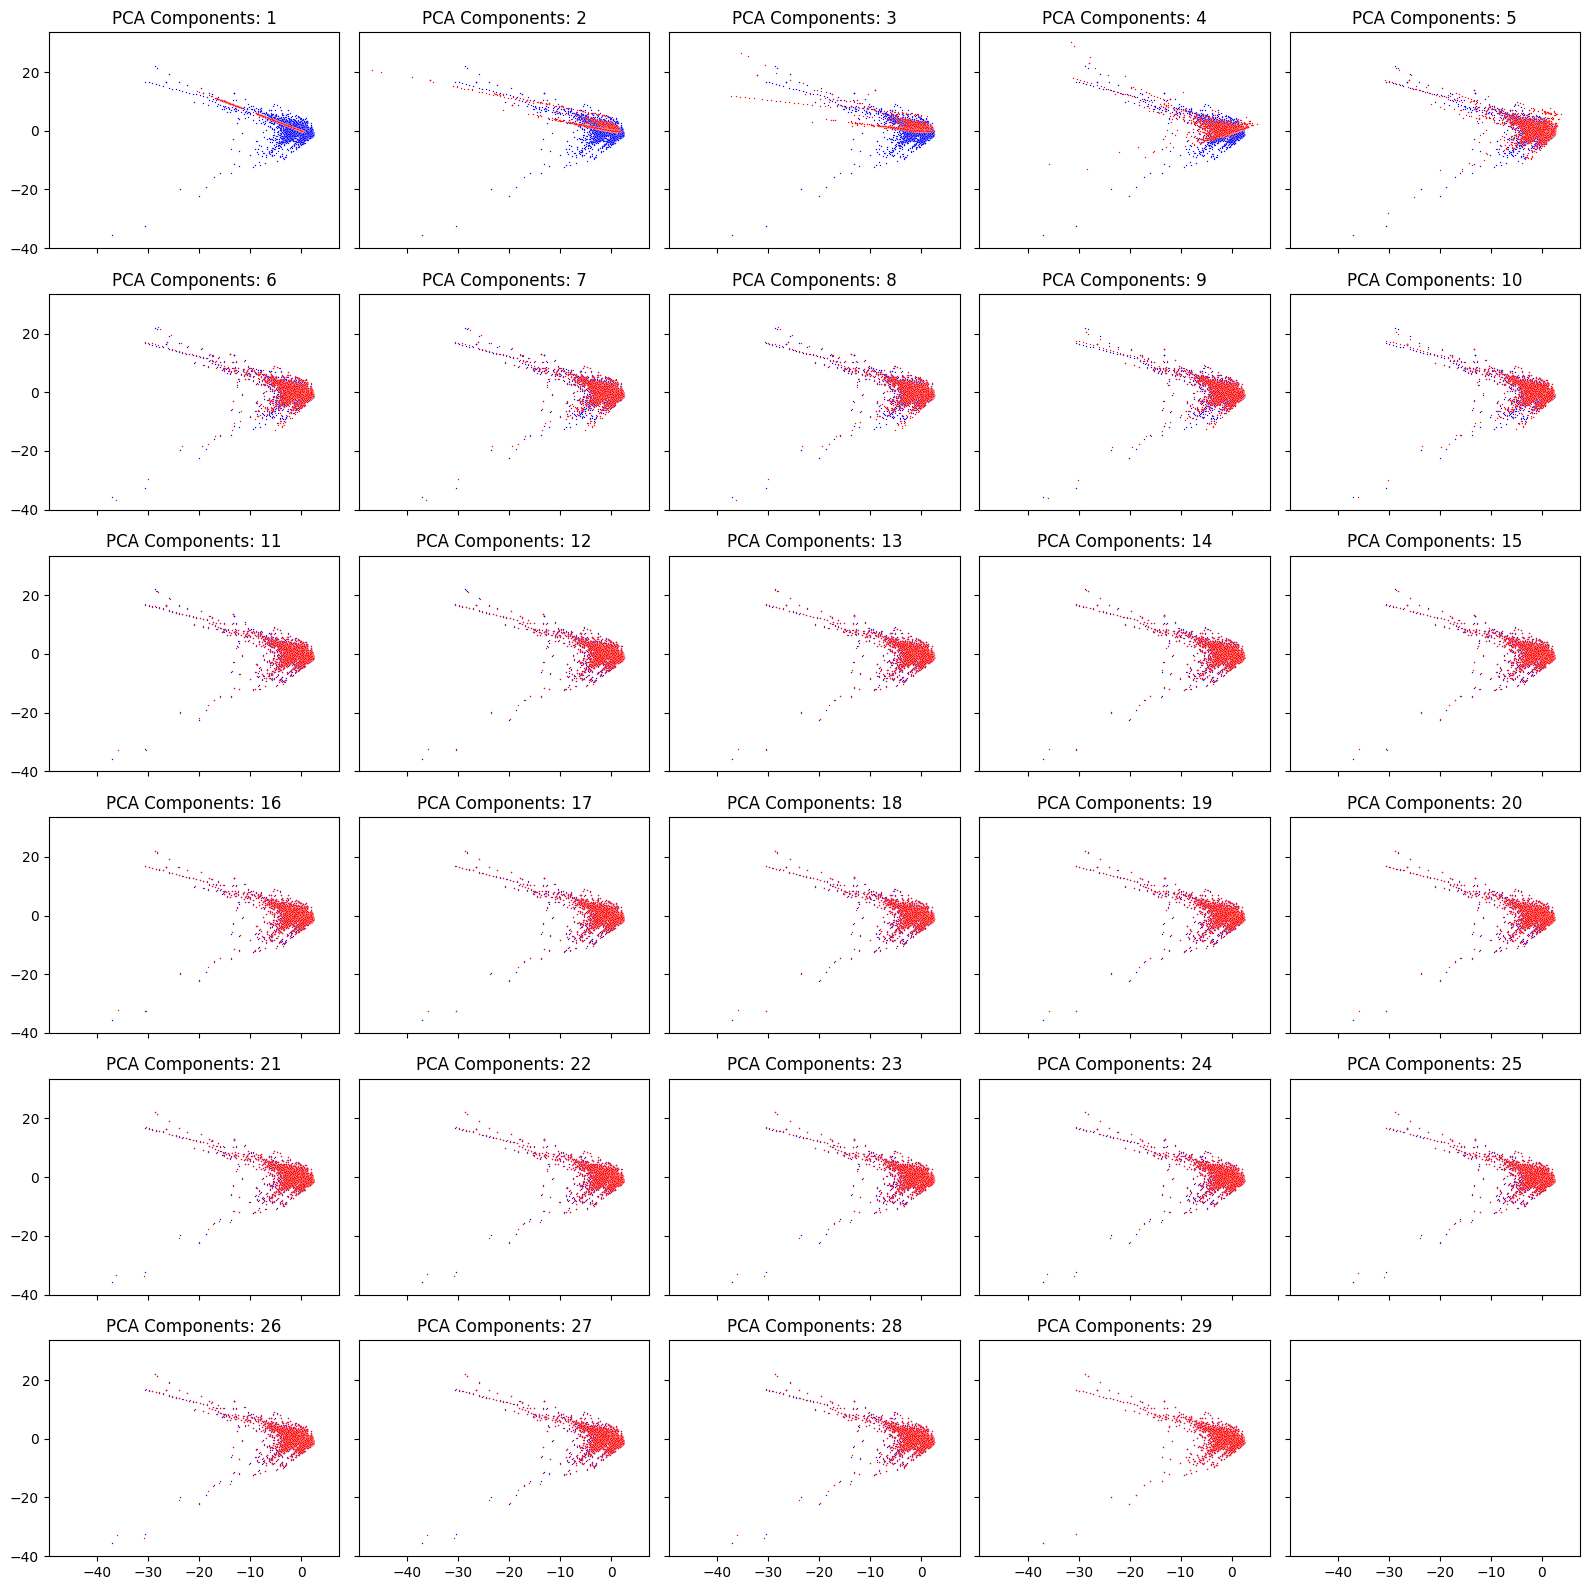

In [22]:
### Visualise the original data overlayered against the PCA inverse transform data:
## Define view parameters
rows = 6
cols = 5
comps = 1

## scaler = StandardScaler()
X_scaled = dfX.to_numpy()

fig, axes = plt.subplots(rows, 
                         cols, 
                         figsize=(16,16), 
                         sharex=True, 
                         sharey=True)

# Scatter of PCA (Black) and original (grey)  
for row in range(rows):
    for col in range(cols):
        try:
            X_new = transform_pca(X_scaled, comps)
            ax = sns.scatterplot(x=X_scaled[:, 0], 
                                 y=X_scaled[:, 1], 
                                 ax=axes[row, col], 
                                 color='blue', 
                                 s=1)
            ax = sns.scatterplot(x=X_new[:, 0], 
                                 y=X_new[:, 1], 
                                 ax=axes[row, col], 
                                 color='red',
                                 s=1)
            ax.set_title(f'PCA Components: {comps}');

            comps += 1
        except:
            pass
plt.tight_layout()

With 10 components we get 81% cumulitive variance - and the inverse transformation looks pretty good ... 
** This time lets run with 3 components

In [23]:
## 10 Component PCA dim reduction - from 29 dims  
pca = PCA(n_components=3)
pca.fit(dfX)
pcadfX = pca.transform(dfX)
print("Original shape: {}".format(str(dfX.shape)))
print("Reduced shape: {}".format(str(pcadfX.shape)))

Original shape: (10492, 29)
Reduced shape: (10492, 3)


In [24]:
dfY.describe()

,Time,Class
count,10492.000000,10492.000000
mean,-0.007177,0.046893
std,1.000123,0.211419
min,-1.996036,0.000000
25%,-0.859208,0.000000
50%,-0.213335,0.000000
75%,0.941345,0.000000
max,1.641552,1.000000


In [26]:
df_pca = dfY[['Time', 'Class']].copy()
for n in range (0, 3):
    df_pca[f'PCA{n}'] = pcadfX[:,n]

## df_pca = pd.DataFrame(pcadfX, columns =['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10'])
 
print(df_pca.describe())
print(df_pca.head())

               Time         Class          PCA0          PCA1          PCA2
count  10492.000000  10492.000000  10492.000000  10492.000000  1.049200e+04
mean      -0.007177      0.046893      0.000000      0.000000  1.083557e-17
std        1.000123      0.211419      5.329870      2.206809  1.951151e+00
min       -1.996036      0.000000     -2.372892    -17.436801 -2.298960e+01
25%       -0.859208      0.000000     -1.207195     -0.832799 -3.356156e-01
50%       -0.213335      0.000000     -1.060302     -0.222723  7.362327e-02
75%        0.941345      0.000000     -0.733243      0.570178  3.254749e-01
max        1.641552      1.000000     62.055939     38.552635  4.228842e+01
            Time  Class      PCA0      PCA1      PCA2
113487 -0.457628      0 -0.670007  1.280597 -0.806514
62296  -0.939117      0 -1.141929  0.712515 -0.345651
244398  1.211213      0 -0.974376 -0.344096 -0.776052
201946  0.827390      0 -1.048305  1.010270 -0.665980
284678  1.639531      0 -1.133934  0.083505 -0

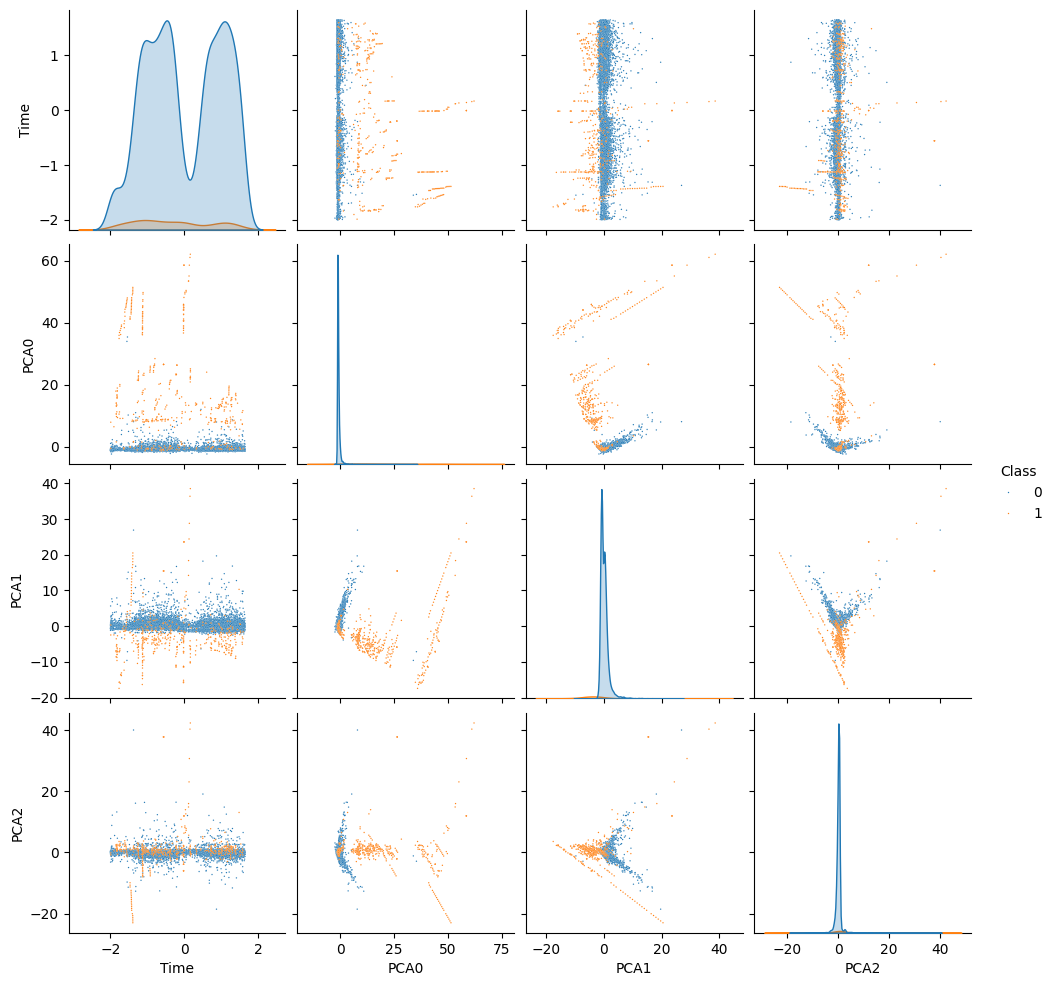

In [27]:
sns.pairplot(df_pca, hue='Class', plot_kws={'s': 1})

Visually, the first two Principle components are the ones that cause real seperation .... 

##### Creating the Training and Test datasets....

In [28]:
   

### Split the data 60:40 for train and test 
x_train, x_test = train_test_split(df_pca, test_size = 0.4, random_state = 42)
### Sort the data by standardised time: 
x_train = x_train.sort_values(by=['Time'])
x_test = x_test.sort_values(by=['Time'])
### Create y_train and y_test from the x_train and x_test - containing only the Class. 
y_train = x_train["Class"]
y_test = x_test["Class"]

x_train.head(10)

,Time,Class,PCA0,PCA1,PCA2
33,-1.996036,0,-1.081007,0.251113,-0.064349
58,-1.995741,0,-1.107877,-0.716418,0.291571
158,-1.994498,0,-1.155774,0.461166,-0.355178
168,-1.994330,0,-0.714707,-1.177544,0.510546
243,-1.993130,0,-0.986740,-0.290733,0.311502
266,-1.992582,0,-1.151522,1.103539,-0.595179
274,-1.992498,0,-1.593566,0.230644,-0.012672
290,-1.992182,0,1.050386,5.658795,-3.179979
313,-1.991845,0,-1.018789,-0.246310,0.275625
320,-1.991655,0,-0.692538,0.740889,-0.539255


In [29]:
### Create a and n datasets to assess class distribution of x .... 
a = x_train[x_train["Class"] == 1]
n = x_train[x_train["Class"] == 0]

a.shape, n.shape


((292, 5), (6003, 5))

In [30]:
a = x_test[x_test["Class"] == 1]
n = x_test[x_test["Class"] == 0]

a.shape, n.shape

((200, 5), (3997, 5))

492 datsets with class 1 (292:200), and 10000 datasets with class 0 (6003:3997)     
Note: all the anomalies are included in the train/test daatsets   

##### Assess the shape of the test and train datasets:

In [31]:
print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))


Shapes:
x_train:(6295, 5)
y_train:(6295,)

x_test:(4197, 5)
y_test:(4197,)



##### Reshape the datasets - the X sets must be 3D, while the y sets should be 2D.      
Make the y sets categorical using keras.utils.to_categorical

In [32]:
### Reshape the x sets
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
input_shape = (x_train.shape[1], 1)
### Categorise the y sets using keras.utils.to_categorical:
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)


In [33]:
print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("input_shape:{}\n".format(input_shape))

Shapes:
x_train:(6295, 5, 1)
y_train:(6295, 2)

x_test:(4197, 5, 1)
y_test:(4197, 2)

input_shape:(5, 1)



##### Create the Diluted TCN model:     
Note: Dilation changes from 1, 2, 4, 8      
Padding is casual, and the activation is ReLu    
Interspaced with SpatialDropout1D    
Output layer uses softmax   

In [101]:

input_layer = Input(shape=(input_shape ))

#Series of temporal convolutional layers with dilations increasing by powers of 2.
conv_1 = Conv1D(filters=128, kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,input_shape=input_shape,
                kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(input_layer)

#Dropout layer after each 1D-convolutional layer
drop_1 = SpatialDropout1D(0.05)(conv_1)

conv_2 = Conv1D(filters=128, kernel_size=2, dilation_rate=2,
                padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(drop_1)

drop_2 = SpatialDropout1D(0.05)(conv_2)

conv_3 = Conv1D(filters=128, kernel_size=2, dilation_rate=4,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(drop_2)

drop_3 = SpatialDropout1D(0.05)(conv_3)

conv_4 = Conv1D(filters=128, kernel_size=2, dilation_rate=8,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                activation='relu')(drop_3)

drop_4 = SpatialDropout1D(0.05)(conv_4)

#Flatten layer to feed into the output layer
flat = Flatten()(drop_4)
### Output layer outputting one of two classes. 
output_layer = Dense(2, activation='softmax')(flat)

TCN = Model(inputs=input_layer, outputs=output_layer)

##### Set-up the model as a function..... 

In [34]:
import keras_tuner

Using TensorFlow backend


In [35]:
def call_existing_code(dilation_rate1, dilation_rate2, dilation_rate3, dilation_rate4, activation, filters):
    input_layer = Input(shape=(input_shape ))

    #Series of temporal convolutional layers with dilations increasing by powers of 2.
    conv_1 = Conv1D(filters=filters, kernel_size=2, dilation_rate=dilation_rate1,
                    padding='causal', strides=1,input_shape=input_shape,
                    kernel_regularizer=regularizers.l2(0.01),
                    activation=activation)(input_layer)

    #Dropout layer after each 1D-convolutional layer
    drop_1 = SpatialDropout1D(0.05)(conv_1)

    conv_2 = Conv1D(filters=filters, kernel_size=2, dilation_rate=dilation_rate2,
                    padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                    activation=activation)(drop_1)

    drop_2 = SpatialDropout1D(0.05)(conv_2)

    conv_3 = Conv1D(filters=filters, kernel_size=2, dilation_rate=dilation_rate3,
                    padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.01),
                    activation=activation)(drop_2)

    drop_3 = SpatialDropout1D(0.05)(conv_3)

    conv_4 = Conv1D(filters=filters, kernel_size=2, dilation_rate=dilation_rate4,
                    padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                    activation=activation)(drop_3)

    drop_4 = SpatialDropout1D(0.05)(conv_4)

    #Flatten layer to feed into the output layer
    flat = Flatten()(drop_4)
    ### Output layer outputting one of two classes. 
    output_layer = Dense(2, activation='softmax')(flat)

    TCN = Model(inputs=input_layer, outputs=output_layer)
    TCN.compile(loss='mean_squared_error',
              optimizer=optimizers.Adam(learning_rate=0.002),
              metrics=['mae', 'accuracy'])
    return TCN

In [36]:
def build_model(hp):
    filters = hp.Int("filters", min_value=64, max_value=256, step=32)
    dilation_rate1 = hp.Int("dilation_rate1", min_value=1, max_value=2, step=1)
    dilation_rate2 = hp.Int("dilation_rate2", min_value=2, max_value=6, step=2)
    dilation_rate3 = hp.Int("dilation_rate3", min_value=4, max_value=16, step=4)
    dilation_rate4 = hp.Int("dilation_rate4", min_value=8, max_value=24, step=4)
    activation = hp.Choice("activation", ["relu", "tanh"])

    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(
        dilation_rate1=dilation_rate1, dilation_rate2=dilation_rate2, dilation_rate3=dilation_rate3, dilation_rate4=dilation_rate4, filters=filters, activation=activation
    )
    return model


In [37]:
build_model(keras_tuner.HyperParameters())

In [38]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_mae",
    max_trials=64,
    executions_per_trial=2,
    overwrite=True,
    directory="beginning-anomaly-detection-using-python-based-dl-master",
    project_name="TCN_credit_card",
)

In [39]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dilation_rate1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
dilation_rate2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 2, 'sampling': 'linear'}
dilation_rate3 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 16, 'step': 4, 'sampling': 'linear'}
dilation_rate4 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 24, 'step': 4, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}


In [40]:
tuner.search(x_train, y_train, epochs=5, validation_split=0.2)

Trial 64 Complete [00h 00m 32s]
val_mae: 0.033124979585409164

Best val_mae So Far: 0.021008272655308247
Total elapsed time: 01h 18m 26s


In [41]:
# Get the top 2 models.
best_models = tuner.get_best_models(num_models=2)
best_model = best_models[0]

In [42]:
best_model.build(x_train.shape)

# Summary of the best model
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 conv1d (Conv1D)             (None, 5, 192)            576       
                                                                 
 spatial_dropout1d (Spatial  (None, 5, 192)            0         
 Dropout1D)                                                      
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 192)            73920     
                                                                 
 spatial_dropout1d_1 (Spati  (None, 5, 192)            0         
 alDropout1D)                                                    
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 192)            73920 

In [43]:
tuner.results_summary()

Results summary
Results in beginning-anomaly-detection-using-python-based-dl-master\TCN_credit_card
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 50 summary
Hyperparameters:
filters: 192
dilation_rate1: 1
dilation_rate2: 6
dilation_rate3: 12
dilation_rate4: 16
activation: tanh
Score: 0.021008272655308247

Trial 28 summary
Hyperparameters:
filters: 192
dilation_rate1: 1
dilation_rate2: 6
dilation_rate3: 12
dilation_rate4: 16
activation: tanh
Score: 0.023806960321962833

Trial 55 summary
Hyperparameters:
filters: 128
dilation_rate1: 1
dilation_rate2: 6
dilation_rate3: 8
dilation_rate4: 8
activation: tanh
Score: 0.024083743803203106

Trial 09 summary
Hyperparameters:
filters: 224
dilation_rate1: 1
dilation_rate2: 4
dilation_rate3: 8
dilation_rate4: 8
activation: tanh
Score: 0.025095388758927584

Trial 21 summary
Hyperparameters:
filters: 224
dilation_rate1: 1
dilation_rate2: 4
dilation_rate3: 8
dilation_rate4: 8
activation: tanh
Score: 0.025176619179546833

Tria

In [44]:
# Evaluate the model on the test data
score = best_model.evaluate(x_test, y_test, verbose=0)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0323701836168766
Test accuracy: 0.020876677706837654


In [45]:
input_layer = Input(shape=(input_shape ))

#Series of temporal convolutional layers with dilations increasing by powers of 2.
conv_1 = Conv1D(filters=192, kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,input_shape=input_shape,
                kernel_regularizer=regularizers.l2(0.01),
                activation='tanh')(input_layer)

#Dropout layer after each 1D-convolutional layer
drop_1 = SpatialDropout1D(0.05)(conv_1)

conv_2 = Conv1D(filters=192, kernel_size=2, dilation_rate=6,
                padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                activation='tanh')(drop_1)

drop_2 = SpatialDropout1D(0.05)(conv_2)

conv_3 = Conv1D(filters=192, kernel_size=2, dilation_rate=12,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.01),
                activation='tanh')(drop_2)

drop_3 = SpatialDropout1D(0.05)(conv_3)

conv_4 = Conv1D(filters=192, kernel_size=2, dilation_rate=16,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                activation='tanh')(drop_3)

drop_4 = SpatialDropout1D(0.05)(conv_4)

#Flatten layer to feed into the output layer
flat = Flatten()(drop_4)
### Output layer outputting one of two classes. 
output_layer = Dense(2, activation='softmax')(flat)

TCN = Model(inputs=input_layer, outputs=output_layer)

##### Compile the TCN - loss is mse, optimizer is Adam, metrics output are 'mae', 'accuracy'            

In [46]:
TCN.compile(loss='mean_squared_error',
              optimizer=optimizers.Adam(lr=0.002),
              metrics=['mae', 'accuracy'])

checkpointer = ModelCheckpoint(filepath="model_TCN_creditcard.h5",
                               verbose=0,
                               save_best_only=True)

TCN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 5, 192)            576       
                                                                 
 spatial_dropout1d_4 (Spati  (None, 5, 192)            0         
 alDropout1D)                                                    
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 192)            73920     
                                                                 
 spatial_dropout1d_5 (Spati  (None, 5, 192)            0         
 alDropout1D)                                                    
                                                                 
 conv1d_6 (Conv1D)           (None, 5, 192)            7392

##### Fit the x_train and y_train data    
Note: Batch size is 128     
No of epochs is set to 10      
TensorBoard support is added in the callbacks      

In [47]:
TCN.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_split=0.2,
          callbacks = [TensorBoard(log_dir='../../logs/TCN1')])

Epoch 1/10
40/40 [==============================] - 9s 116ms/step - loss: 7.2740 - mae: 0.1696 - accuracy: 0.9607 - val_loss: 2.7540 - val_mae: 0.1040 - val_accuracy: 0.9809
Epoch 2/10
40/40 [==============================] - 5s 116ms/step - loss: 1.2840 - mae: 0.0896 - accuracy: 0.9839 - val_loss: 0.3922 - val_mae: 0.0775 - val_accuracy: 0.9857
Epoch 3/10
40/40 [==============================] - 4s 108ms/step - loss: 0.1800 - mae: 0.0726 - accuracy: 0.9875 - val_loss: 0.0638 - val_mae: 0.0684 - val_accuracy: 0.9857
Epoch 4/10
40/40 [==============================] - 4s 105ms/step - loss: 0.0460 - mae: 0.0659 - accuracy: 0.9871 - val_loss: 0.0338 - val_mae: 0.0621 - val_accuracy: 0.9857
Epoch 5/10
40/40 [==============================] - 5s 118ms/step - loss: 0.0344 - mae: 0.0626 - accuracy: 0.9865 - val_loss: 0.0308 - val_mae: 0.0586 - val_accuracy: 0.9865
Epoch 6/10
40/40 [==============================] - 4s 108ms/step - loss: 0.0329 - mae: 0.0604 - accuracy: 0.9853 - val_loss: 0.03

Epoch 1/10
40/40 [==============================] - 4s 95ms/step - loss: 0.0292 - mae: 0.0537 - accuracy: 0.9881 - val_loss: 0.0262 - val_mae: 0.0534 - val_accuracy: 0.9913
Epoch 2/10


C:\Users\tanopsgeo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 5s 121ms/step - loss: 0.0287 - mae: 0.0537 - accuracy: 0.9865 - val_loss: 0.0265 - val_mae: 0.0603 - val_accuracy: 0.9849
Epoch 3/10
40/40 [==============================] - 4s 90ms/step - loss: 0.0280 - mae: 0.0533 - accuracy: 0.9885 - val_loss: 0.0253 - val_mae: 0.0542 - val_accuracy: 0.9913
Epoch 4/10
40/40 [==============================] - 3s 69ms/step - loss: 0.0282 - mae: 0.0536 - accuracy: 0.9867 - val_loss: 0.0255 - val_mae: 0.0461 - val_accuracy: 0.9936
Epoch 5/10
40/40 [==============================] - 3s 78ms/step - loss: 0.0273 - mae: 0.0524 - accuracy: 0.9883 - val_loss: 0.0246 - val_mae: 0.0523 - val_accuracy: 0.9913
Epoch 6/10
40/40 [==============================] - 3s 85ms/step - loss: 0.0269 - mae: 0.0528 - accuracy: 0.9885 - val_loss: 0.0249 - val_mae: 0.0488 - val_accuracy: 0.9857
Epoch 7/10
40/40 [==============================] - 4s 98ms/step - loss: 0.0267 - mae: 0.0502 - accuracy: 0.9885 - val_loss: 0.0240 - val_mae: 0.

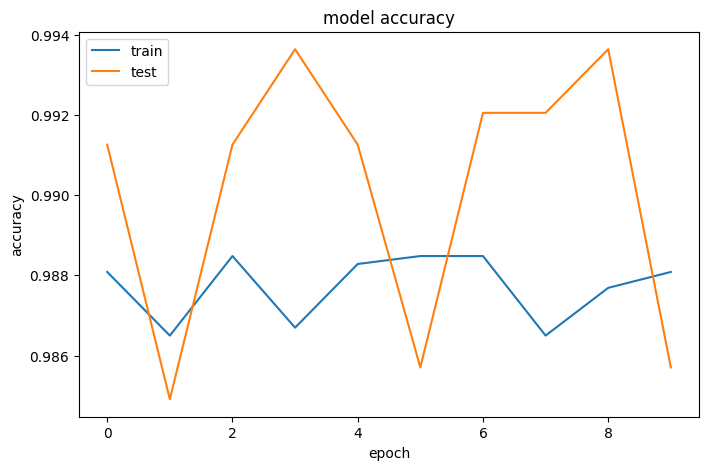

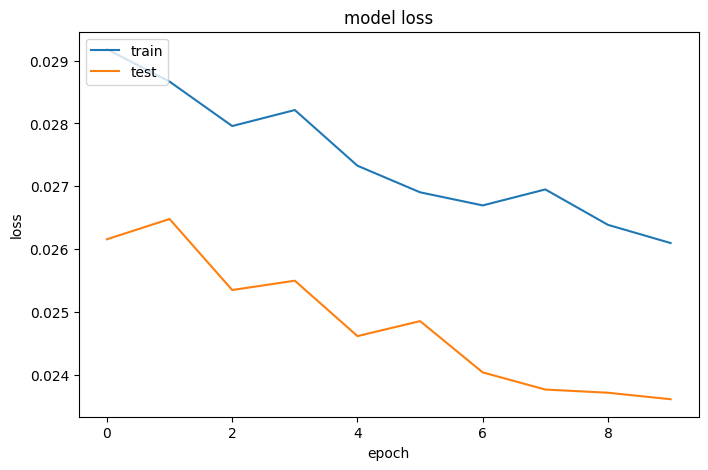

In [48]:
history = TCN.fit(x_train, y_train,
            batch_size=128,
            epochs=10,
            verbose=1,
            validation_split=0.2,
            callbacks = [checkpointer])
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
score = TCN.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02586550824344158
Test accuracy: 0.05210531875491142


In [50]:
from sklearn.metrics import roc_auc_score

preds = TCN.predict(x_test)
### Round function uses a threshold of 0.5 ....
y_pred = np.round(preds)
print(y_pred)
auc = roc_auc_score( y_pred, y_test)
print("AUC: {:.2%}".format (auc))

132/132 [==============================] - 2s 13ms/step
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
AUC: 98.69%


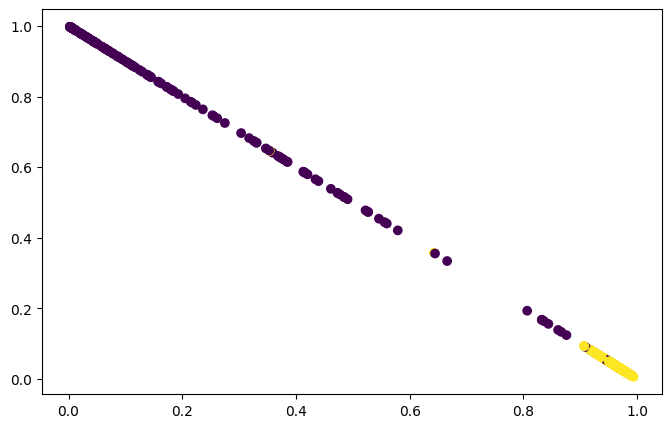

In [51]:
plt.scatter(preds[:,0], preds[:,1], c=y_test[:,0])

In [52]:
ypred_0 = np.count_nonzero(y_pred[:,0] == 0)
ypred_1 = np.count_nonzero(y_pred[:,0] == 1)

# Print the counts
print("Count of 0s:", ypred_0)
print("Count of 1s:", ypred_1)

Count of 0s: 150
Count of 1s: 4047


#### Threshold - assign  a threshold to define the cut-off between normal and anomaly .....  

In [62]:
# Define a threshold for anomaly detection
threshold = 0.9 # Adjust this threshold as needed

# Assuming y_pred contains the model's predictions for the test data
# y_pred should be a list of values between 0 and 1 representing anomaly scores

# Create an array of 0s and 1s based on the threshold
anom_thresh = [1 if score > threshold else 0 for score in preds[:,0]]
# anomalies will now contain 1s for samples considered anomalies and 0s for non-anomalies

print(anom_thresh)
print(anom_thresh.count(0))

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

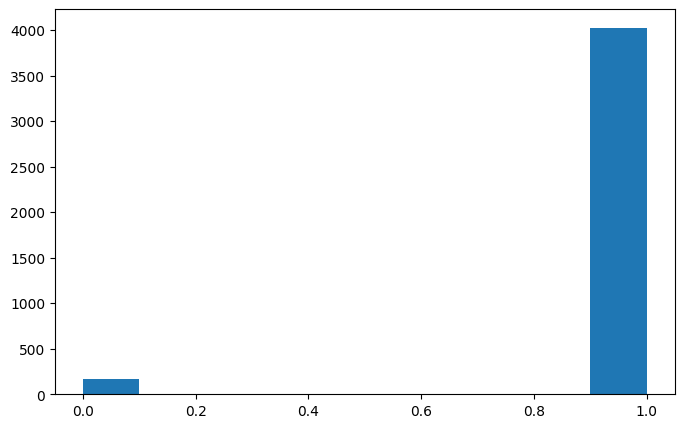

In [63]:
plt.hist(anom_thresh)
plt.show()

In [64]:
threshold = 0.9
### NumPy array called y_pred1 with the same shape and size as the y_test array:
y_pred1=np.zeros_like(y_test)
### Assigns a value of 1 to elements where the condition is True (i.e., where preds[:, 0] is greater than the threshold)
y_pred1[:,0] = np.where(preds[:,0] > threshold, 1, 0)

y_pred1[:,1] = np.where(preds[:,0] > threshold, 0, 1)
print(y_pred1)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [65]:
count_0 = np.count_nonzero(y_pred1[:,1] == 0)
count_1 = np.count_nonzero(y_pred1[:,1] == 1)

# Print the counts
print("Count of 0s:", count_0)
print("Count of 1s:", count_1)

Count of 0s: 4029
Count of 1s: 168


In [66]:
print(classification_report(y_test, y_pred))
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3997
           1       0.99      0.74      0.85       200

   micro avg       0.99      0.99      0.99      4197
   macro avg       0.99      0.87      0.92      4197
weighted avg       0.99      0.99      0.99      4197
 samples avg       0.99      0.99      0.99      4197

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3997
           1       0.98      0.82      0.90       200

   micro avg       0.99      0.99      0.99      4197
   macro avg       0.99      0.91      0.95      4197
weighted avg       0.99      0.99      0.99      4197
 samples avg       0.99      0.99      0.99      4197



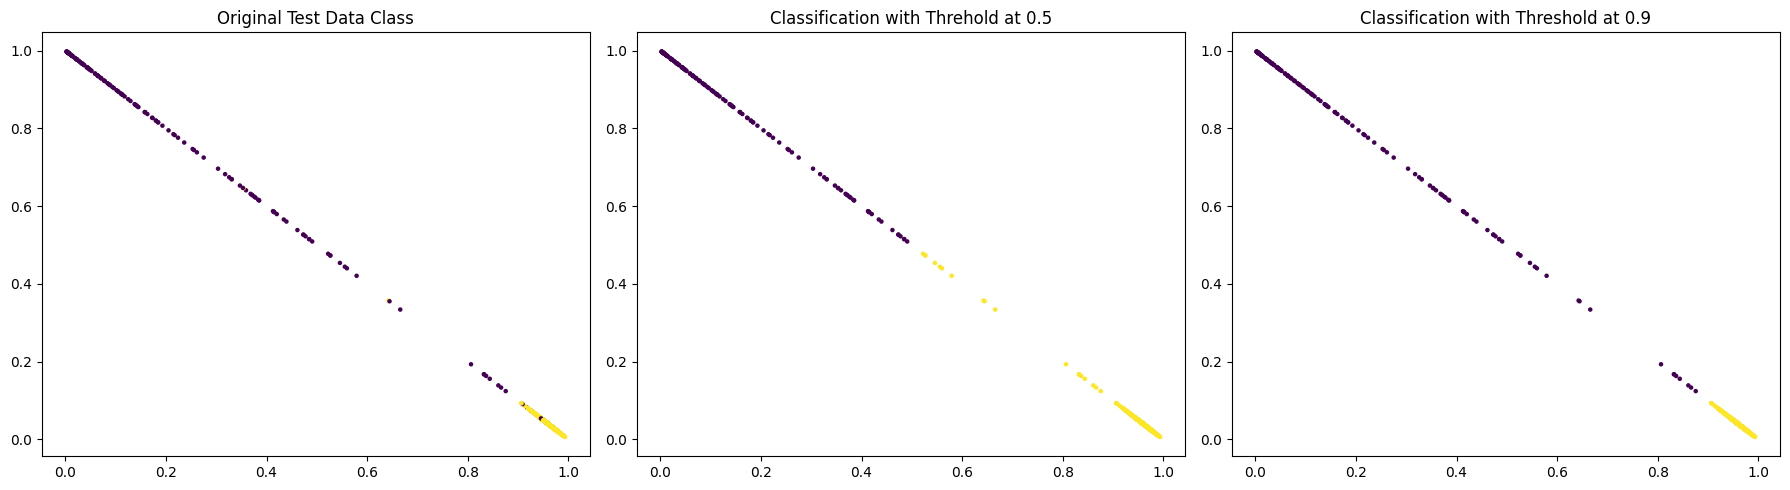

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(preds[:,0], preds[:,1], c=y_test[:,0], s=5)
axes[1].scatter(preds[:,0], preds[:,1], c=y_pred[:,0], s=5)
axes[2].scatter(preds[:,0], preds[:,1], c=y_pred1[:,0], s=5)
### Set Titles for each plot: 
axes[0].set_title('Original Test Data Class')
axes[1].set_title('Classification with Threhold at 0.5')
axes[2].set_title('Classification with Threshold at 0.9')

plt.tight_layout()
plt.show()

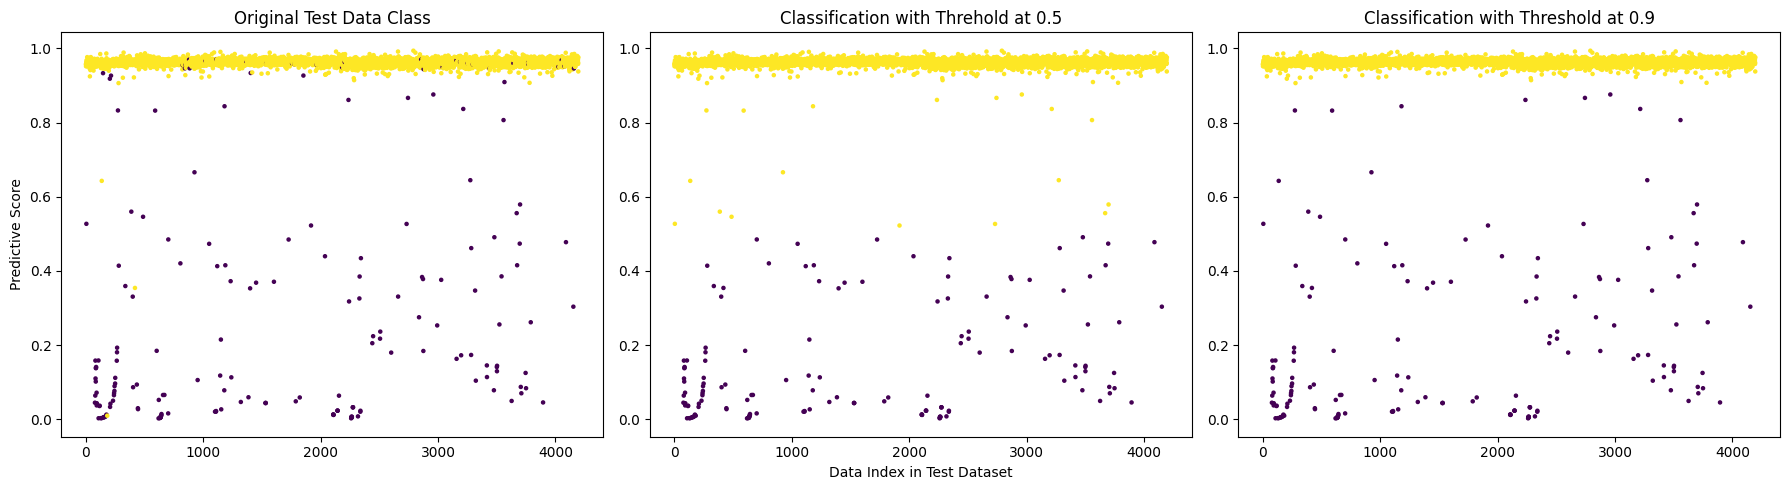

In [76]:
index = np.arange(len(preds))
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(index, preds[:,0], c=y_test[:,0], s=5)
axes[1].scatter(index, preds[:,0], c=y_pred[:,0], s=5)
axes[2].scatter(index, preds[:,0], c=y_pred1[:,0], s=5)
### Set Titles for each plot: 
axes[0].set_title('Original Test Data Class')
axes[1].set_title('Classification with Threhold at 0.5')
axes[2].set_title('Classification with Threshold at 0.9')
### Set axis labels:
axes[0].set_ylabel("Predictive Score")
axes[1].set_xlabel("Data Index in Test Dataset")
plt.tight_layout()
plt.show()

##### Observation: even with PCA - a number of the anomalies are still buried deep into the 'yellow normal'. Threshold of 0.9 seperates the data - but some are still mis-classified.       

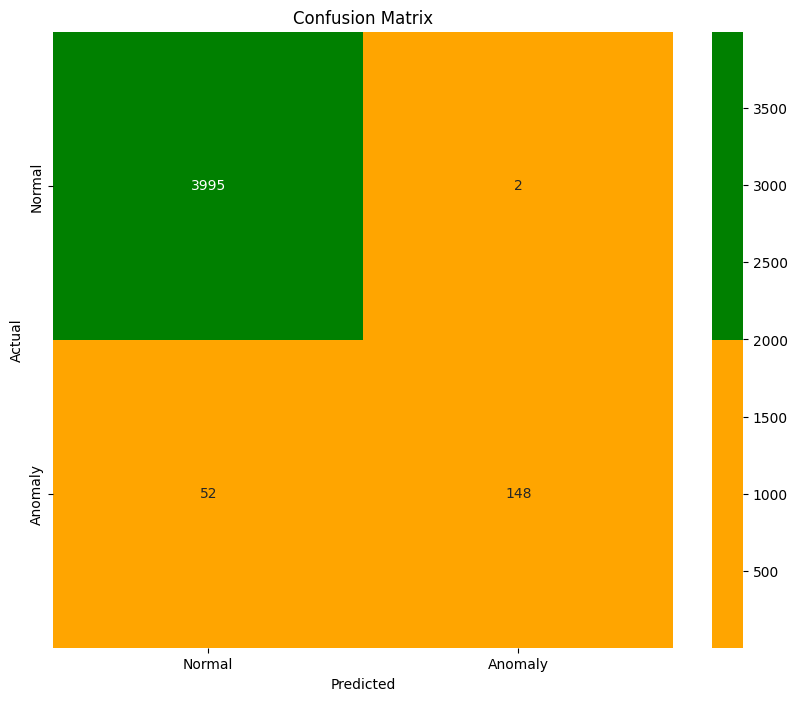

In [69]:
viz = Visualization()
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)
viz.draw_confusion_matrix(y_test2, y_pred2)

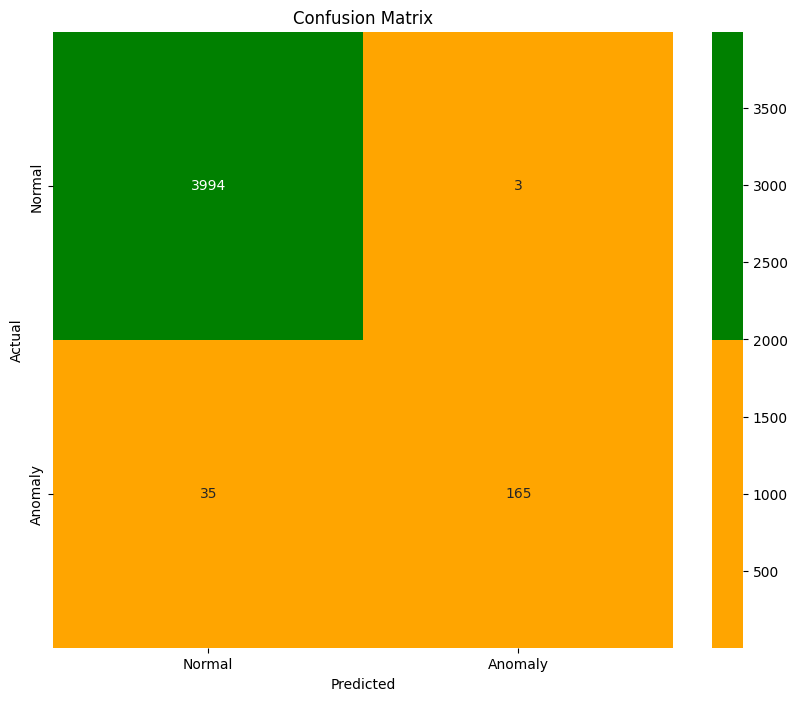

In [70]:
viz = Visualization()
y_pred2 = np.argmax(y_pred1, axis=1)
y_test2 = np.argmax(y_test, axis=1)
viz.draw_confusion_matrix(y_test2, y_pred2)

##### At threshold 0.5 - Only 148 of the 198 anomalies were accurately classified - but 52 were incorrectly classified 

##### At threshold 0.9 - 165 anomalies were accurately classified - but 35(+3) were incorrect.  

##### Observation - PCA reduction of dims down to 3 improves the classification of normal data - but anomalies are still buried.  